In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Добейтесь значения MAE на тестовой выборке не больше 8.

## Исследовательский анализ данных

In [2]:
df_labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
df_labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
datagen = ImageDataGenerator(rescale=1/255)

In [5]:
datagen_flow = datagen.flow_from_dataframe(
        dataframe=df_labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [6]:
features, target = next(datagen_flow)

Выведем часть фотографий из датасета:

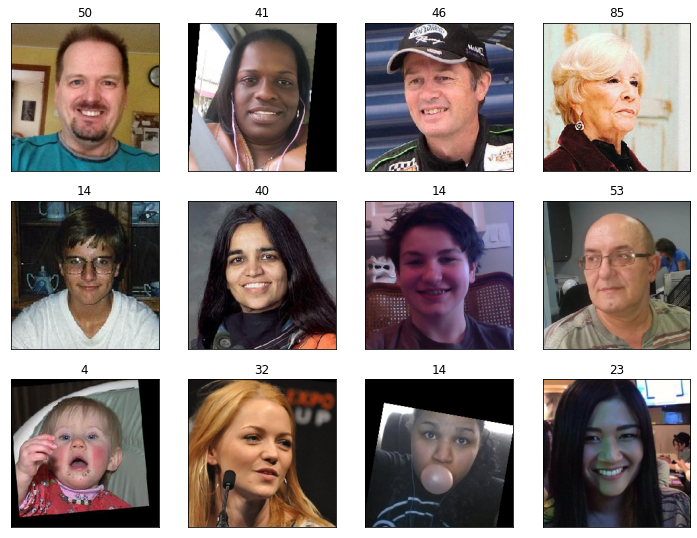

In [7]:
fig = plt.figure(figsize=(10, 10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Посмотрим на размер выборки:

In [8]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Построим график распределения возраста в выборке:

In [9]:
df_labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

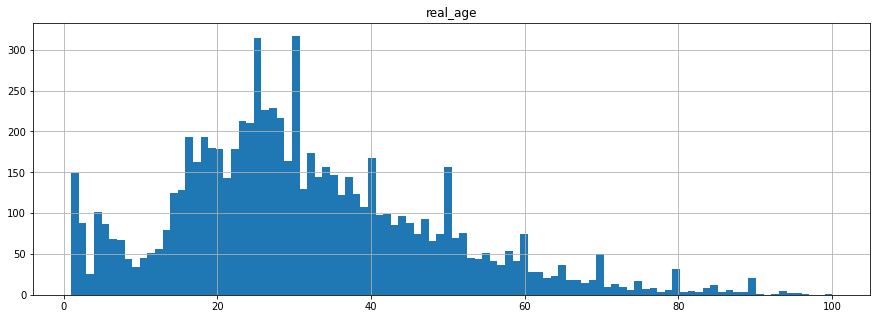

In [10]:
df_labels.hist(bins=100, figsize=(15, 5))

По графику видим, что распределение похоже на нормальное. Судя по минимуму и максимуму, выбросов нет. Большинство значений находятся в диапазоне от 20 до 41 года.

Итоги:

Для увеличения объёма данных можем использовать аугментации:  горизонтальный флип, небольшие сдвиги изображений по вертикали и горизонтали.

Общая ориентация фотографий вертикальная, иногда встречается фотографии с небольшим отклонением от вертикальной оси, необходимости в поворотах нет. Также в датасете присутствуют черно-белые фотографии. Размер изображений мы приведем к единому перед обучением модели.

## Обучение модели

Для обучения будем использовать нейронную сеть ResNet50.

### Функции

Создадим функции для тестовой и тренировочной выборок, функции для создания и обучения модели:

```python

def load_test(path):
        
    test_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(             
    dataframe = pd.read_csv(path + 'labels.csv'),
    directory= (path + '/final_files'),   
    x_col='file_name',
    y_col='real_age',   
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=12345)
    
    return test_datagen_flow

def load_train(path):
    
    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(        
    dataframe = pd.read_csv(path + 'labels.csv'),
    directory= (path + '/final_files'),
    x_col='file_name',
    y_col='real_age',  
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=12345)
    
    return train_datagen_flow

def create_model(input_shape):
    
    backbone = ResNet50(     
               input_shape=(224, 224, 3),
               weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
               include_top=False)
    
    optimizer = Adam(lr=0.0001)
    
    model = Sequential()    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='relu'))  
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=3,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              batch_size=batch_size, 
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

### Результат обучения модели в GPU-тренажёре:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps

Epoch 1/3
356/356 - 102s - loss: 285.4608 - mean_absolute_error: 12.3585 - val_loss: 392.7735 - val_mean_absolute_error: 14.7726

Epoch 2/3
356/356 - 94s - loss: 100.8734 - mean_absolute_error: 7.6222 - val_loss: 177.4660 - val_mean_absolute_error: 10.3341

Epoch 3/3
356/356 - 94s - loss: 82.4080 - mean_absolute_error: 6.9796 - val_loss: 89.1961 - val_mean_absolute_error: 7.1933

119/119 - 10s - loss: 89.1961 - mean_absolute_error: 7.1933
Test MAE: 7.1933

```

## Анализ обученной модели

При обучении модели были использованы:
- нейросеть `ResNet50`;
- оптимизатор `Adam` с шагом градиентного спуска равным 0.0001;
- функция  активации - `relu`;
- функция потерь - `MSE`;
- метрика оценки качества модели - `MAE`.

Значение `MAE` = 7.2

Скорость обучения: 5 минут

Полученная модель отвечает условию задачи, т.к. метрика `MAE` имеет значение менее 8. 
Качество модели позволяет решать поставленную бизнесом задачу "Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы".